In [10]:
 %load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from pipeline import eval_pipeline, HierarchicalImputer, CoordinateTransformer, WindDirectionTransformer, DropColumnsTransformer, RainTodayTransformer, ExpandDateTransformer, sample, report_results, ShapeDebugger, BinningTransformer, LabelBinarizerPipelineFriendly
from persistence import load_or_fit
# For data manipulation
import pandas as pd
import numpy as np
import pandas as pd
# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
rains = pd.read_csv('../data/weatherAUS.csv')
rains = rains.dropna(subset=['RainTomorrow'])
# Convierto la variable 'Date' a formato tipo "datetime" de Pandas

rains_x = rains.drop(columns=['RainTomorrow'])  # Drop the target column from features
rains_y = np.where(rains['RainTomorrow'] == "Yes", 1, 0)                 # Target variable

# Split the dataset
rnd_seed = 42   # For reproducibility         
ftest = 0.20    # Fracción de datos para "train"

X_train, X_test, y_train, y_test = train_test_split(rains_x, rains_y,
                                                    test_size=ftest,
                                                    stratify=rains_y,
                                                    random_state=rnd_seed)

print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (113754, 22)
Valores de y_train: 113754
Dimension de X_test: (28439, 22)
Valores de y_test: 28439


In [4]:
coordinates = pd.read_csv("../data/worldcities.csv")
coordinates["Location"] = coordinates["city"]
coordinates.drop(columns=["city"], inplace = True)
coordinates = coordinates[coordinates["country"] == "Australia"]

city_coords = {
    'Albury': (-36.0785, 146.9136),
    'BadgerysCreek': (-33.8813, 150.7282),
    'Cobar': (-31.8667, 145.7667),
    'CoffsHarbour': (-30.3026, 153.1137),
    'Moree': (-29.4706, 149.8392),
    'Newcastle': (-32.9283, 151.7817),
    'NorahHead': (-33.2202, 151.5433),
    'NorfolkIsland': (-29.0408, 167.9541),
    'Penrith': (-33.7675, 150.6931),
    'Richmond': (-33.5982, 150.7581),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'WaggaWagga': (-35.0433, 147.3587),
    'Williamtown': (-32.7951, 151.8118),
    'Wollongong': (-34.4278, 150.8931),
    'Canberra': (-35.2809, 149.1300),
    'Tuggeranong': (-35.4167, 149.1000),
    'MountGinini': (-35.4471, 148.9685),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7582, 144.2814),
    'Sale': (-38.1100, 147.0737),
    'MelbourneAirport': (-37.6692, 144.8411),
    'Melbourne': (-37.8136, 144.9631),
    'Mildura': (-34.1850, 142.1625),
    'Nhil': (-35.2060, 141.6450),
    'Portland': (-38.3516, 141.5878),
    'Watsonia': (-37.7139, 145.0875),
    'Dartmoor': (-37.7251, 141.2843),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9203, 145.7710),
    'GoldCoast': (-28.0167, 153.4000),
    'Townsville': (-19.2589, 146.8183),
    'Adelaide': (-34.9285, 138.6007),
    'MountGambier': (-37.8321, 140.7807),
    'Nuriootpa': (-34.4973, 138.9966),
    'Woomera': (-31.1395, 136.7984),
    'Albany': (-35.0285, 117.8837),
    'Witchcliffe': (-33.7015, 115.0911),
    'PearceRAAF': (-31.9131, 115.9741),
    'PerthAirport': (-31.9402, 115.9676),
    'Perth': (-31.9505, 115.8605),
    'SalmonGums': (-33.3937, 121.2060),
    'Walpole': (-34.9639, 115.8106),
    'Hobart': (-42.8821, 147.3272),
    'Launceston': (-41.4391, 147.1349),
    'AliceSprings': (-23.6980, 133.8807),
    'Darwin': (-12.4634, 130.8456),
    'Katherine': (-14.4686, 132.2678),
    'Uluru': (-25.3444, 131.0369)
}

# Categorical => numerical

Se transforman las direcciones cardinales en grados, ej NE -> 0.22

Se transforma la ubicacion (Location) en latitud y longitud, ej Albury => (-36.0785, 146.9136)

In [ ]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])
rain_today_pipeline = Pipeline(steps = [
      ("rain_today_imputer", SimpleImputer(fill_value='No', strategy="constant")),
      ("rain_today_binarizer", LabelBinarizerPipelineFriendly()),
])

mean_imputer = ColumnTransformer(
    transformers=[
        ("mode", SimpleImputer(strategy="most_frequent"), ["WindGustDir", "WindDir9am", "WindDir3pm"]),
        ("mean", SimpleImputer(strategy="mean"), ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                                                  'Temp3pm']),
      ("rain_today", rain_today_pipeline, ["RainToday"])
    ], remainder='passthrough'
)

parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'imputer': [mean_imputer],
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)
report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

In [64]:
def wind_direction_transformer(value):
  {direction: i * 22.5 for i, direction in enumerate(
            ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
        )}[value]

rain_today_pipeline = Pipeline(steps = [
      ("rain_today_imputer", SimpleImputer(fill_value='No', strategy="constant")),
      ("rain_today_binarizer", LabelBinarizerPipelineFriendly()),
])

mean_imputer = ColumnTransformer(
    transformers=[
        ("mode", SimpleImputer(strategy="most_frequent"), ["WindGustDir", "WindDir9am", "WindDir3pm"]),
        ("mean", SimpleImputer(strategy="mean"), ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                                                  'Temp3pm']),
      ("rain_today", rain_today_pipeline, ["RainToday"])
    ], remainder='passthrough'
)

num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
  ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),

    ("imputer", mean_imputer),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])

parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)
report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leocenturion/Documents/postgrados/ia/rain-in-australia/models/pipeline.py", line 157, in transform
    X["WindGustDirDeg"] = X["WindGustDir"].map(self.direction_to_degrees)
                          ~^^^^^^^^^^^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


In [61]:
rain_today_pipeline = Pipeline(steps = [
      ("rain_today_imputer", SimpleImputer(fill_value='No', strategy="constant")),
      ("rain_today_binarizer", LabelBinarizerPipelineFriendly()),
])

mean_imputer = ColumnTransformer(
    transformers=[
        ("mode", SimpleImputer(strategy="most_frequent"), ["WindGustDir", "WindDir9am", "WindDir3pm"]),
        ("mean", SimpleImputer(strategy="mean"), ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                                                  'Temp3pm']),
      ("rain_today", rain_today_pipeline, ["RainToday"])
    ], remainder='passthrough'
)
Pipeline(steps=[("x", mean_imputer)]).fit_transform(x)

array([['W', 'NW', 'SE', ..., 0, '2015-09-15', 'Newcastle'],
       ['S', 'N', 'SSE', ..., 0, '2011-05-19', 'Albury'],
       ['WSW', 'WSW', 'SSW', ..., 0, '2012-01-11', 'MelbourneAirport'],
       ...,
       ['S', 'WSW', 'WSW', ..., 0, '2015-05-13', 'Penrith'],
       ['NW', 'NW', 'W', ..., 0, '2013-06-05', 'Williamtown'],
       ['WNW', 'WSW', 'W', ..., 0, '2012-03-09', 'Sale']], dtype=object)

In [52]:
pd.DataFrame(LabelBinarizerPipelineFriendly().fit_transform(SimpleImputer(fill_value='No', strategy="constant").fit_transform(x[['RainToday']])))[0].unique()

test


array([0, 1])

###  Missclassifications

In [183]:
num_minmax_logit_preproc =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
], memory="pipeline_cache")
x_t = num_minmax_logit_preproc.fit_transform(x)

In [185]:
x_t.to_csv('./processed.csv')

/tmp/ipykernel_382068/300980677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missclassified['target'] = y[y != y_pred]


<Figure size 1000x1000 with 0 Axes>

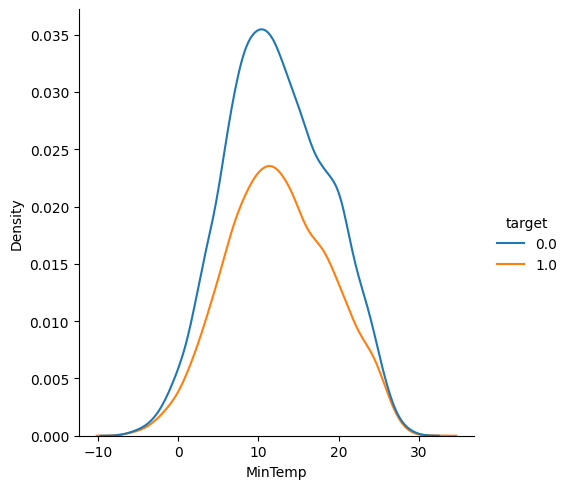

<Figure size 1000x1000 with 0 Axes>

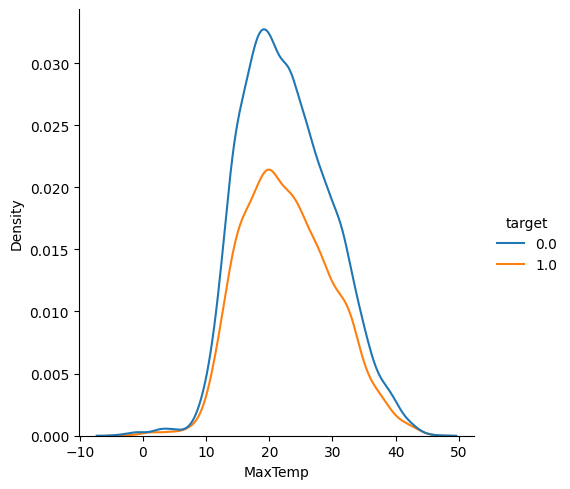

<Figure size 1000x1000 with 0 Axes>

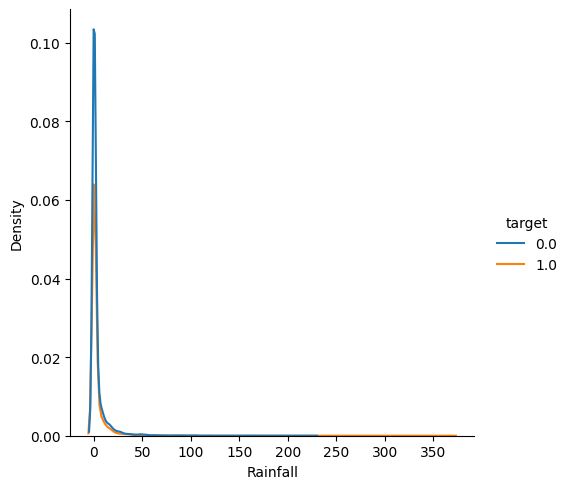

<Figure size 1000x1000 with 0 Axes>

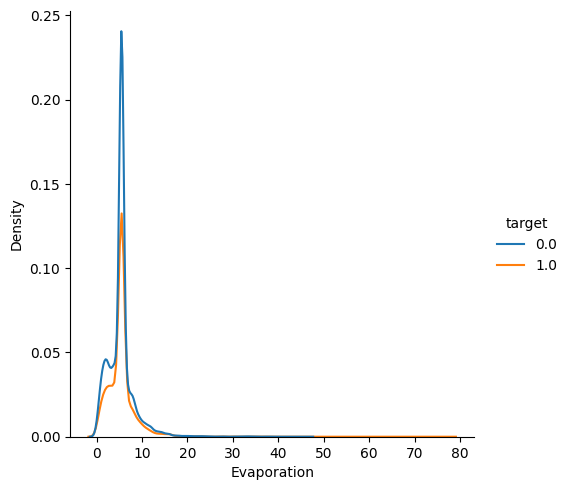

<Figure size 1000x1000 with 0 Axes>

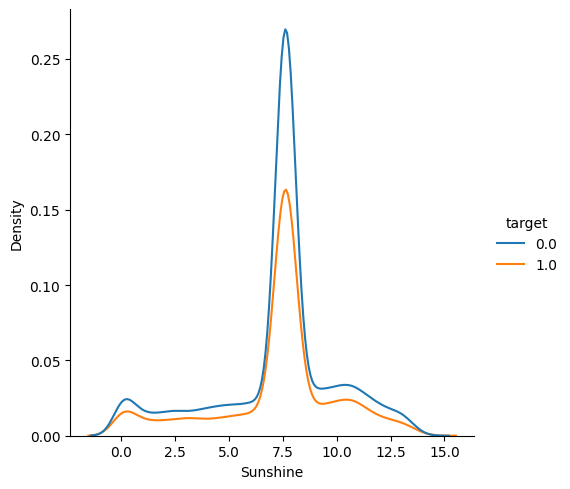

<Figure size 1000x1000 with 0 Axes>

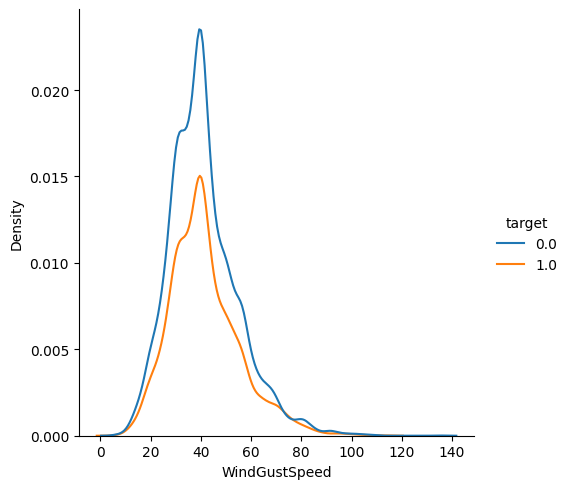

<Figure size 1000x1000 with 0 Axes>

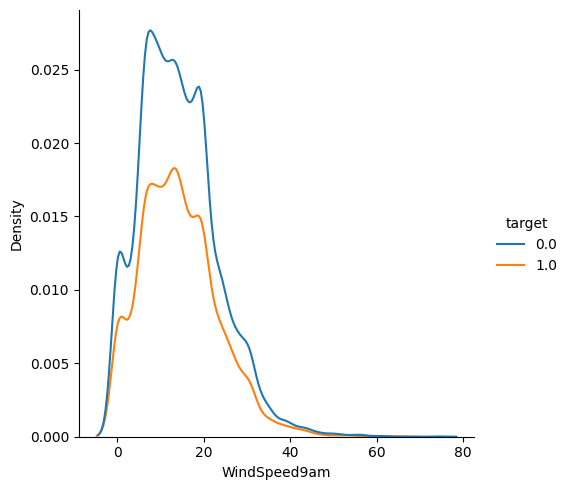

<Figure size 1000x1000 with 0 Axes>

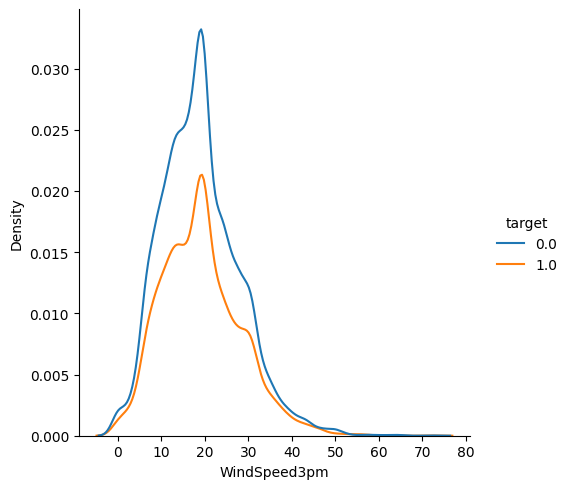

<Figure size 1000x1000 with 0 Axes>

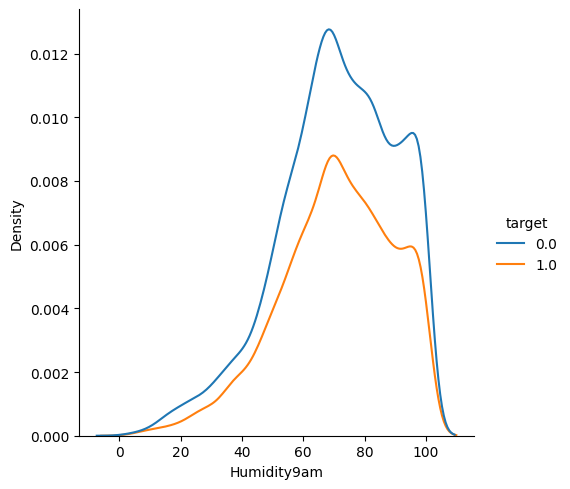

<Figure size 1000x1000 with 0 Axes>

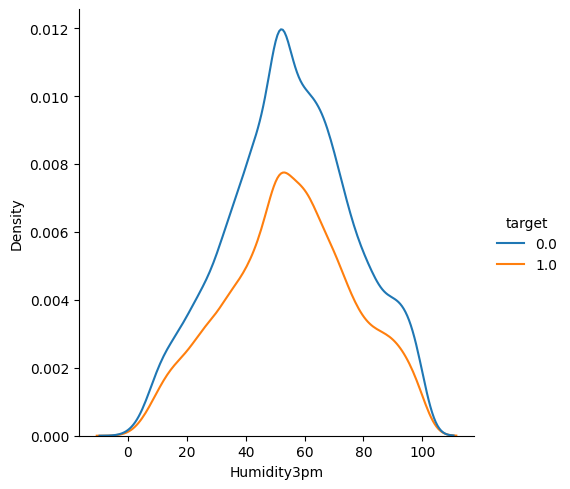

<Figure size 1000x1000 with 0 Axes>

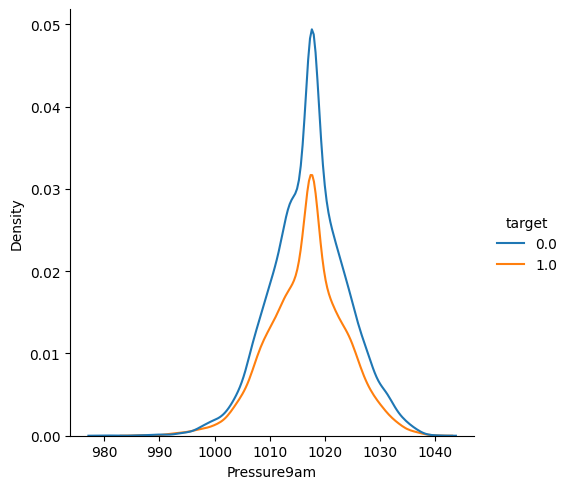

<Figure size 1000x1000 with 0 Axes>

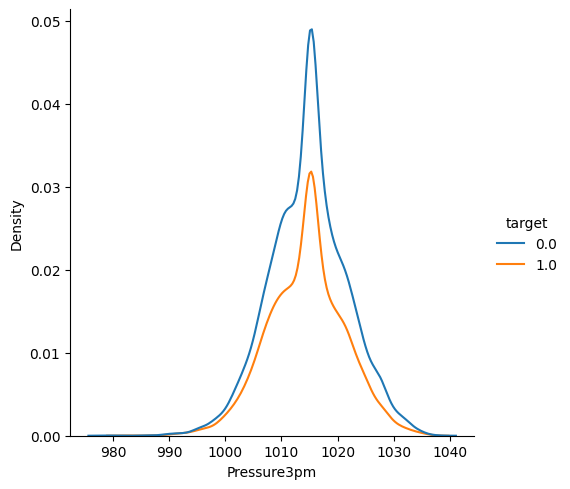

<Figure size 1000x1000 with 0 Axes>

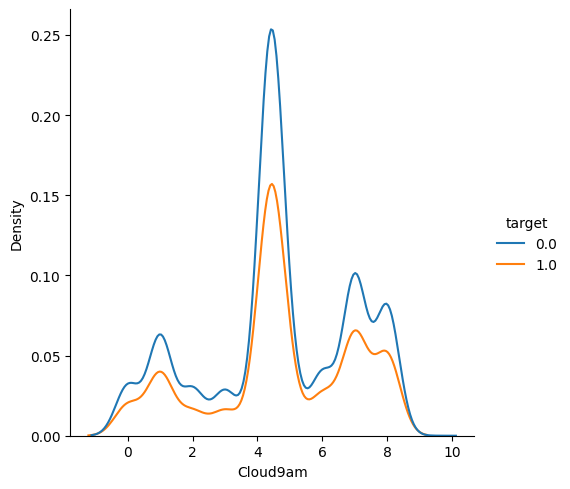

<Figure size 1000x1000 with 0 Axes>

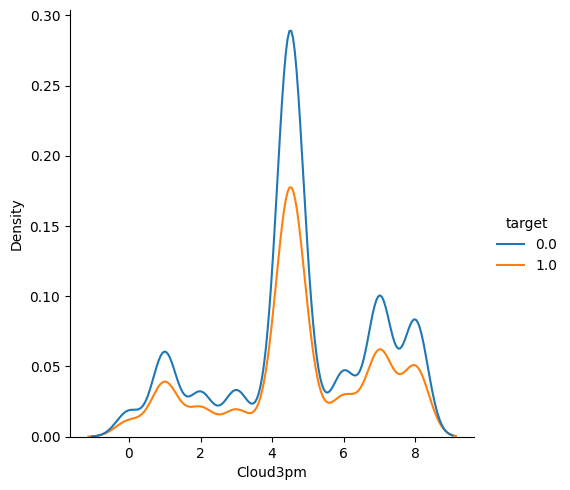

<Figure size 1000x1000 with 0 Axes>

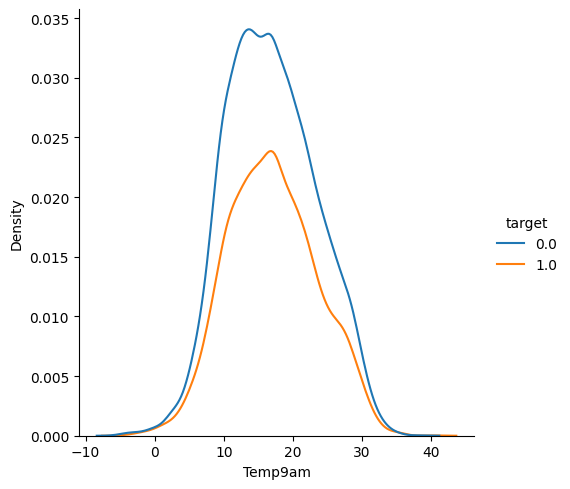

<Figure size 1000x1000 with 0 Axes>

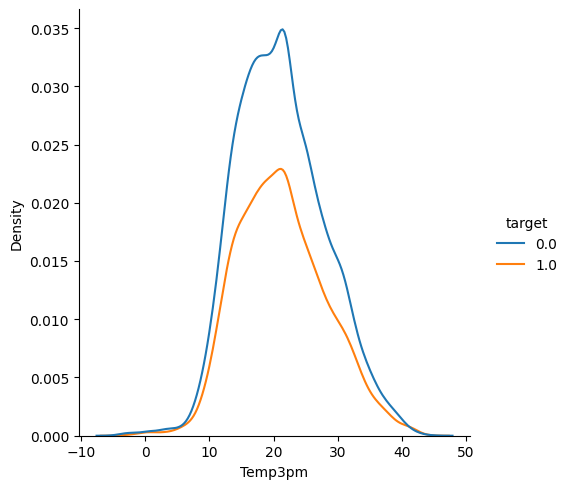

<Figure size 1000x1000 with 0 Axes>

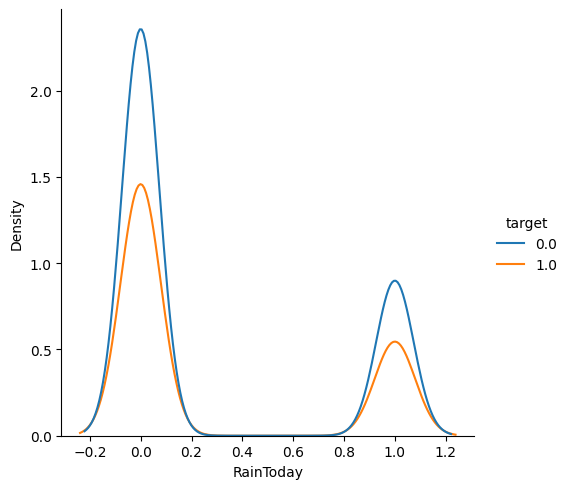

<Figure size 1000x1000 with 0 Axes>

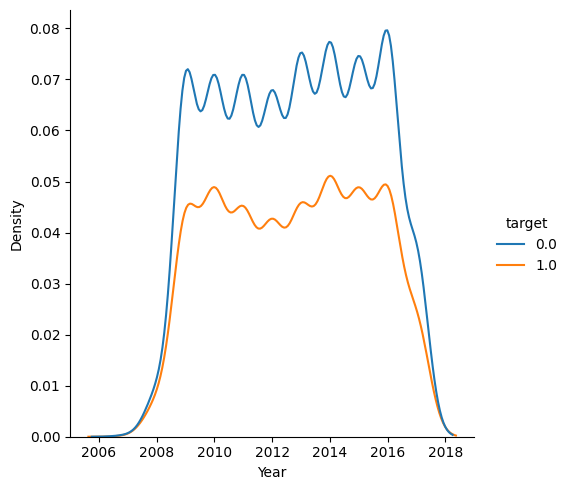

<Figure size 1000x1000 with 0 Axes>

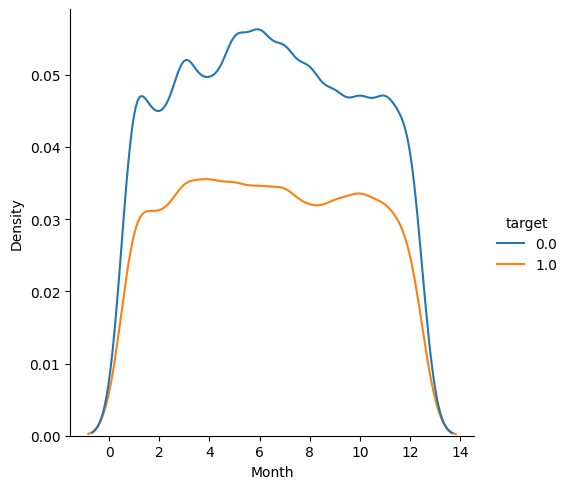

<Figure size 1000x1000 with 0 Axes>

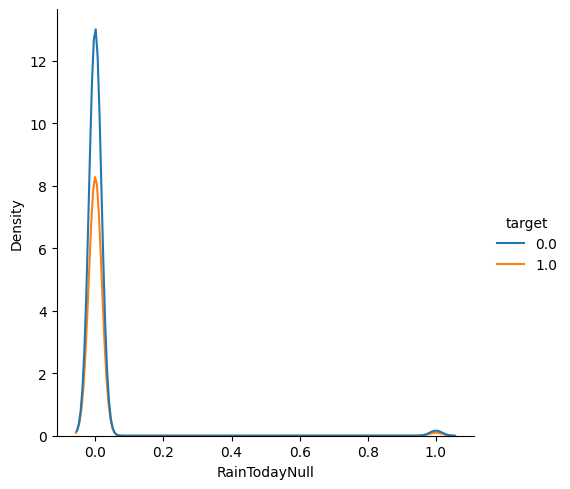

<Figure size 1000x1000 with 0 Axes>

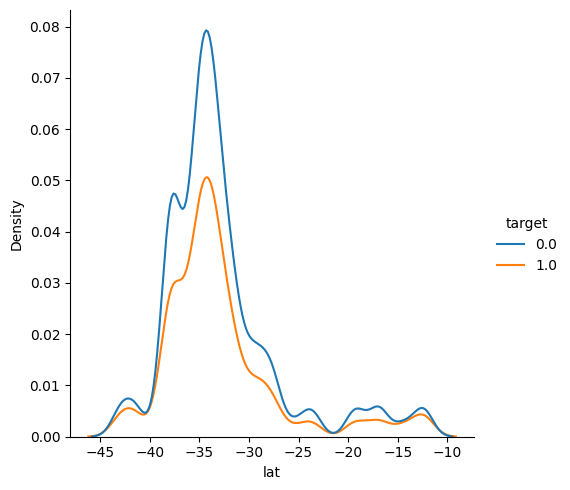

<Figure size 1000x1000 with 0 Axes>

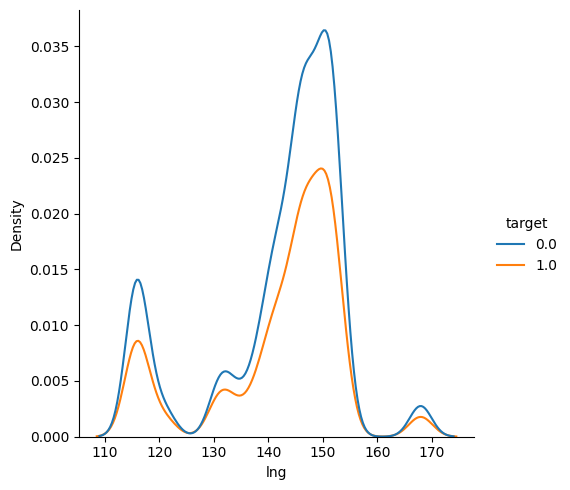

<Figure size 1000x1000 with 0 Axes>

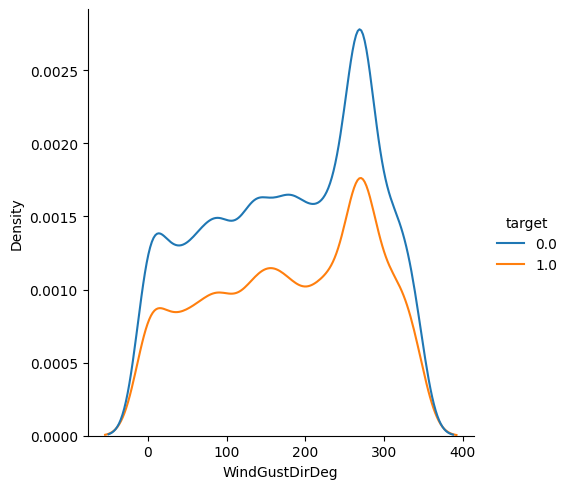

<Figure size 1000x1000 with 0 Axes>

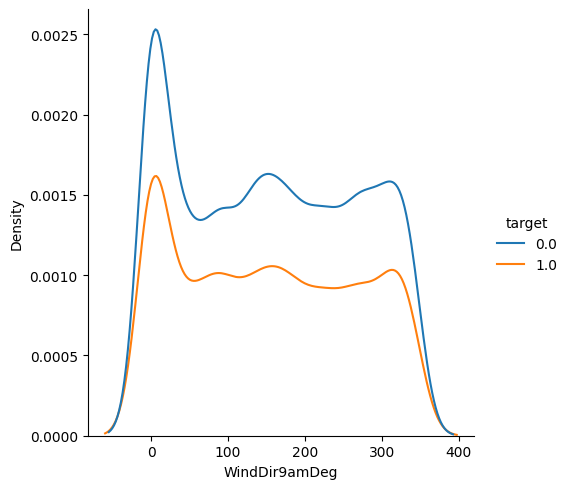

<Figure size 1000x1000 with 0 Axes>

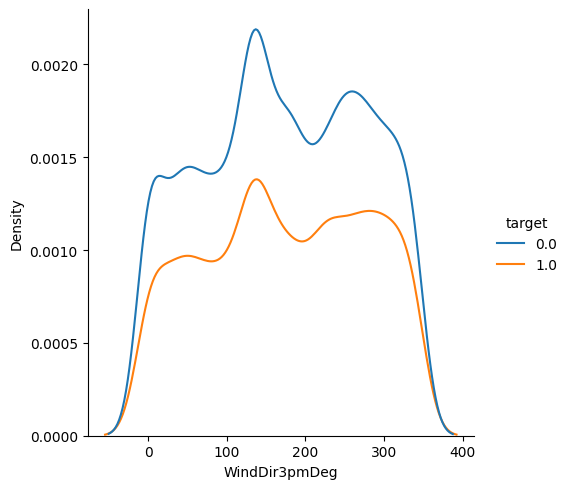

In [56]:
missclassified = x_t[(y_pred != y).reset_index(drop=True)]
missclassified['target'] = y[y != y_pred]
for c in x_t.columns:
  plt.figure(figsize=(10,10))
  sns.displot(data=missclassified, x=c, hue='target', kind="kde")
  plt.show()

##  Elasticnet

In [104]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.95],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
    'logistic_regression__C': [2.0, 5.0],
    'logistic_regression__max_iter': [1000]
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


{'logistic_regression__C': 5.0, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.95, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}


Accuracy: 0.8026267208186085

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7813728985347294


In [ ]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__class_weight,param_logistic_regression__l1_ratio,param_logistic_regression__penalty,param_logistic_regression__solver,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,4.070496,0.781790,0.724000,0.198347,"{1: 0.75, 0: 0.25}",0.25,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.645747,0.637705,0.615649,0.619556,0.604491,0.624630,0.015026,3
7,4.736079,0.021802,0.829117,0.088446,"{1: 0.75, 0: 0.25}",0.75,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.646816,0.640984,0.614987,0.618930,0.605172,0.625378,0.015880,1
9,2.340384,0.029444,0.389741,0.022670,"{1: 0.75, 0: 0.25}",0.95,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.646816,0.640984,0.614458,0.618930,0.605172,0.625272,0.015951,2


In [155]:
pd.DataFrame(gs_fitted.best_estimator_.named_steps['logistic_regression'].coef_, columns=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDeg', 'WindDir9amDeg', 'WindDir3pmDeg']).T.abs().sort_values(by=0, ascending=False)

,0
Pressure3pm,13.663893
Pressure9am,9.439823
WindGustSpeed,6.620914
Humidity3pm,5.442283
Rainfall,4.234356
MaxTemp,2.349363
WindSpeed3pm,1.901980
Temp3pm,1.849281
Sunshine,1.847856
RainTodayNull,1.773773


Vemos como cambia la precision y el recall cambiando el valor umbral

In [ ]:
probas = pd.DataFrame(gs_fitted.predict_proba(X_train))

In [ ]:
report_results(y_train, np.where(probas[1] > 0.9, 1, 0))

Exploramos mas el rango $0.25 <= l1 0.75$

In [85]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.25, 0.35, 0.45, 0.65, 0.75],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Saving: num-minmax-logit-elastic-8370.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.45, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': StandardScaler()}


Accuracy: 0.80264430261793

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7813424075884704


In [139]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__class_weight,param_logistic_regression__l1_ratio,param_logistic_regression__penalty,param_logistic_regression__solver,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,3.859030,0.963758,0.701767,0.175408,"{1: 0.75, 0: 0.25}",0.35,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601185,0.613223,0.609650,0.006998,3
5,3.271553,0.524254,0.598792,0.159636,"{1: 0.75, 0: 0.25}",0.45,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601185,0.613223,0.609650,0.006998,3
7,3.886000,0.993439,0.688643,0.193535,"{1: 0.75, 0: 0.25}",0.65,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601695,0.613730,0.609854,0.006931,2
9,2.723910,0.231482,0.407015,0.027385,"{1: 0.75, 0: 0.25}",0.75,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.617496,0.615649,0.601227,0.601695,0.614238,0.610061,0.007099,1


Exploramos mas el rango $0.0.75 <= l1 1.0$

In [84]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory = "pipeline_cache")


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.75, 0.80, 0.85, 0.90, 0.95, 1.0],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
    'logistic_regression__C': [100],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Saving: num-minmax-logit-elastic-7903.pkl
{'logistic_regression__C': 100, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.75, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}


Accuracy: 0.8026970480158939

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7814600454207973


In [ ]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

## Binning

In [144]:

num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("binning", ColumnTransformer(transformers=[
        ("bin_with_slope", BinningTransformer(), ["Rainfall", "Evaporation"])
    ], remainder='passthrough')),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)

report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Saving: num-minmax-logit-2947.pkl


Accuracy: 0.8025476027216626

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7801648291421255
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6221716654419613


## Polynomial expansion

Pressure3pm     13.663893
Pressure9am      9.439823
WindGustSpeed    6.620914
Humidity3pm      5.442283
Rainfall         4.234356
MaxTemp          2.349363


In [161]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("column_transformer", ColumnTransformer(transformers=[
        ("poly_exp", PolynomialFeatures(degree=3), ["Pressure3pm", "Pressure9am", "WindGustSpeed", "Humidity3pm", "Rainfall", "MaxTemp"])
    ], remainder='passthrough')),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory="pipeline_cache")


parameters = {
    'scaler': [StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__C': [5.0],
    'logistic_regression__max_iter': [1000]
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)

report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Saving: num-minmax-logit-1887.pkl


Accuracy: 0.8076023700265486

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87     88252
           1       0.55      0.74      0.63     25502

    accuracy                           0.81    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.81      0.82    113754


 Roc auc Report:
 0.7817914824465155
{'logistic_regression__C': 5.0, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6106417537780231


## Nonlinear transform

In [180]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("column_transformer", ColumnTransformer(transformers=[
        ("log", FunctionTransformer(np.log1p), ["Rainfall", "Evaporation"]),
        ("sin_degree", FunctionTransformer(np.sin), ["WindGustDirDeg", "WindDir9amDeg", "WindDir3pmDeg"]),
        ("cos_degree", FunctionTransformer(np.cos), ["WindGustDirDeg", "WindDir9amDeg", "WindDir3pmDeg"])
    ], remainder='passthrough')),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory="pipeline_cache")


parameters = {
    'scaler': [MinMaxScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__C': [5.0, 100],
    'logistic_regression__max_iter': [1000],
    'logistic_regression__l1_ratio': [0.75, 0.80, 0.85, 0.90, 0.95, 1.0],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)

report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Saving: num-minmax-logit-9472.pkl


Accuracy: 0.7983279708845403

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86     88252
           1       0.54      0.75      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.74    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7811675139769595
{'logistic_regression__C': 100, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.8, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}
0.6177136788293962


In [181]:
pd.DataFrame(gs_fitted.best_estimator_.named_steps['logistic_regression'].coef_, columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDegSin', 'WindDir9amDegSin', 'WindDir3pmDegSin',
       'WindGustDirDegSin', 'WindDir9amDegSin', 'WindDir3pmDegSin']).T.abs().sort_values(by=0, ascending=False)

,0
Year,13.709753
RainToday,9.339283
Temp3pm,5.271173
Pressure3pm,5.073461
Pressure9am,1.722060
lat,1.555150
WindGustDirDegSin,1.465224
MinTemp,1.243830
RainTodayNull,1.236172
Humidity3pm,1.147467


# One hot encoding categorical features


In [73]:
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

numerical_transformer = Pipeline(steps=[
    ("minmax", MinMaxScaler())
])


transform_columns = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, ["Location","WindGustDir", "WindDir9am", "WindDir3pm"]),
        ("num", numerical_transformer, ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Year', 'Month'])
    ]
)


ohe_pipeline = Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("drop_date", DropColumnsTransformer(columns=["Date"])),
    ("preproc", transform_columns),
    ("logistic_regression", LogisticRegression()),
], memory="pipeline_cache")


In [74]:
parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__C': [1, 50, 100]
}
clf = GridSearchCV(ohe_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="ohe-logit", force=True)
 
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)
print(gs_fitted.scorer_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(11375, 111)
Saving: ohe-logit-4398.pkl
{'logistic_regression__C': 100, 'logistic_regression__class_weight': {1: 0.6, 0: 0.4}, 'logistic_regression__penalty': 'l2'}
0.6215773140563278
make_scorer(f1_score, response_method='predict', average=binary)


(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(9100, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)


(9100, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)


(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)


(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(9100, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)


(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)


(9100, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(9100, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)
(2275, 111)


In [69]:
report_results(y_train, gs_fitted.predict(X_train))

Accuracy: 0.8062485714788051

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.55      0.75      0.63     25502

    accuracy                           0.81    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.84      0.81      0.82    113754


 Roc auc Report:
 0.7845296252278586


## OHE con newton-cholesky

In [146]:
parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__solver': ['newton-cholesky']
}
clf = GridSearchCV(ohe_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.3)
gs_fitted = load_or_fit(clf, x, y, name="ohe-logit-nc")

print(gs_fitted.best_params_)
print(gs_fitted.best_score_)
print(gs_fitted.scorer_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Saving: ohe-logit-nc-5197.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'newton-cholesky'}
0.6286214215567321
make_scorer(f1_score, response_method='predict', average=binary)


In [147]:
report_results(y_train, gs_fitted.predict(X_train))

Accuracy: 0.803417901788069

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.55      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7819664462614495


# Exploration

In [83]:
num_minmax_p =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
 ])

x, y = sample(X_train, y_train)

x_t = num_minmax_p.fit_transform(x)

In [84]:
x_t.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp3pm,RainToday,Year,Month,RainTodayNull,lat,lng,WindGustDirDeg,WindDir9amDeg,WindDir3pmDeg
0,16.5,19.6,0.0,5.435133,7.518325,56.0,19.0,28.0,68.0,77.0,...,17.5,0,2013,7,0,-34.4331,150.8831,0.0,0.0,0.0
1,9.8,18.7,14.2,5.435133,7.518325,89.0,52.0,50.0,52.0,67.0,...,15.6,1,2014,10,0,-38.1000,147.0667,292.5,270.0,270.0
2,12.2,23.1,0.0,5.435133,7.518325,43.0,13.0,24.0,55.0,51.0,...,21.5,0,2014,3,0,-34.9639,115.8106,135.0,67.5,135.0
3,4.4,19.4,0.0,1.200000,7.518325,19.0,0.0,11.0,99.0,51.0,...,19.2,0,2010,6,0,-33.6000,150.7500,45.0,0.0,45.0
4,11.3,35.5,0.0,5.435133,7.518325,43.0,4.0,15.0,52.0,17.0,...,34.8,0,2016,11,0,-33.7511,150.6942,315.0,270.0,270.0


In [63]:
x_t.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDeg', 'WindDir9amDeg', 'WindDir3pmDeg'],
      dtype='object')

In [ ]:
y_t = y.reset_index(drop=True)
x_t['target'] = y
for c in x_t.columns:
  plt.figure(figsize=(10,10))
  sns.displot(data=x_t, x=c, hue='target', kind="kde")
  plt.show()

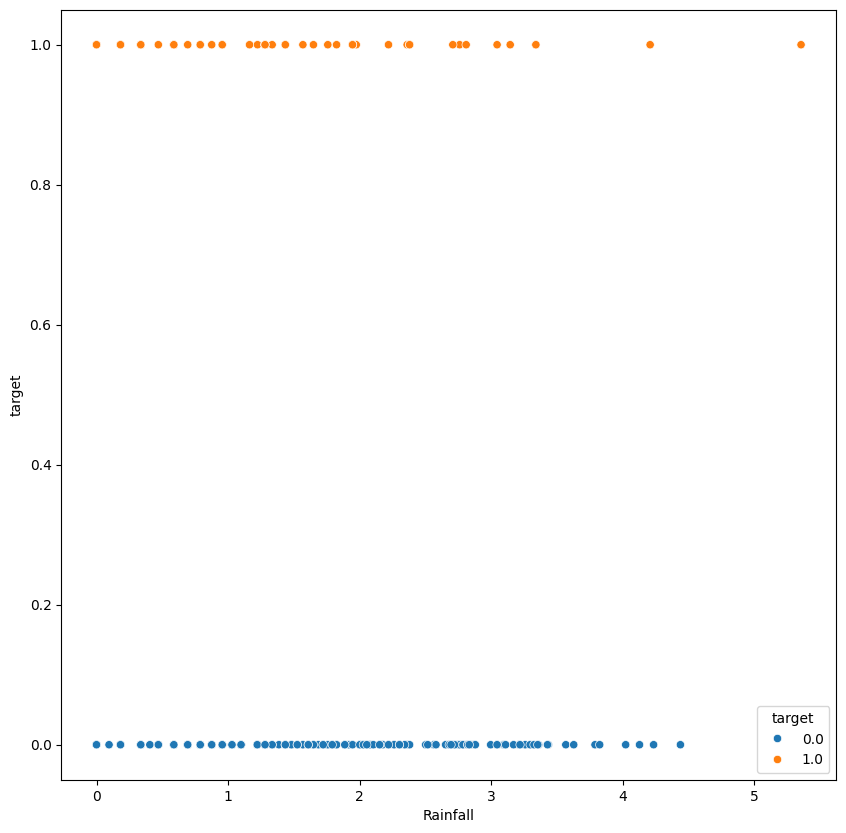

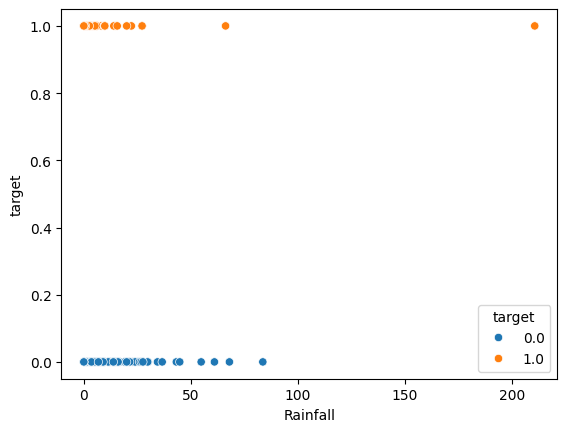

(array([8.452e+03, 7.570e+02, 7.520e+02, 5.070e+02, 4.070e+02, 2.750e+02,
        1.450e+02, 5.000e+01, 2.300e+01, 7.000e+00]),
 array([0.        , 0.54847969, 1.09695939, 1.64543908, 2.19391877,
        2.74239847, 3.29087816, 3.83935785, 4.38783755, 4.93631724,
        5.48479693]),
 <BarContainer object of 10 artists>)

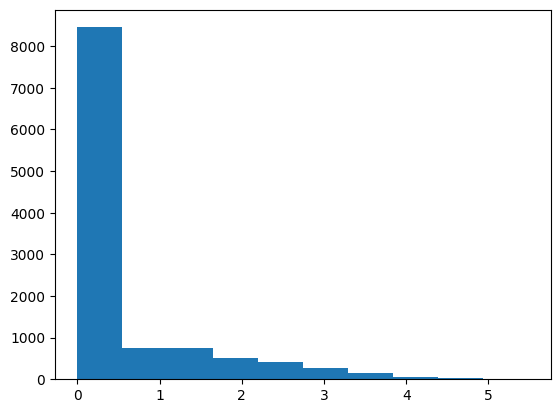

In [121]:
y_t = y.reset_index(drop=True)
x_t['target'] = y
plt.figure(figsize=(10,10))
sns.scatterplot(data=x_t, x=np.log(x_t['Rainfall'] + 1), y='target', hue='target')
plt.show()
sns.scatterplot(data=x_t, x=x_t['Rainfall'], y='target', hue='target')
plt.show()
plt.hist(x=np.log(x_t['Rainfall'] + 1), bins=10)


In [109]:
x_t['Rainfall'].describe()

count    11375.000000
mean         2.393218
std          9.078005
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max        240.000000
Name: Rainfall, dtype: float64

In [35]:
from sklearn.preprocessing import KBinsDiscretizer

x_2 = x.dropna()
trans = KBinsDiscretizer(n_bins=10, strategy='uniform', encode="onehot-dense").fit_transform(x_2[['Rainfall']])


In [81]:
np.hstack([x_2[['Rainfall']], trans])

array([[ 0. ,  1. ,  0. , ...,  0. ,  0. ,  0. ],
       [23. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0.2,  1. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. , ...,  0. ,  0. ,  0. ]])

In [58]:
(trans * x_2['Rainfall']).shape

ValueError: operands could not be broadcast together with shapes (4445,10) (4445,) 

In [80]:
trans * x_2['Rainfall'].to_frame().values

array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , 23. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0.2,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

(4445,)